In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage, signal
import numpy.linalg as LA
from cv2 import imread, resize, GaussianBlur, subtract, KeyPoint, INTER_LINEAR, INTER_NEAREST

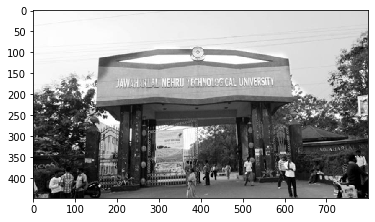

In [91]:
gray_img = imread("jntu1.jpeg",0)
gray_img =gray_img.astype(np.float64)
plt.imshow(gray_img,cmap = plt.get_cmap('gray'))

In [92]:
type(gray_img[0,0])

numpy.float64

# GENARATION OF SCALE SPACE

In [93]:
#we will create the base image up-sampling the image and applying the gaussian blur
def createBaseImage(img, sigma):
    resized_img = resize(img, None, fx=2, fy=2, interpolation = INTER_LINEAR)
    return GaussianBlur(resized_img,None ,sigmaX = 1.6, sigmaY = 1.6)

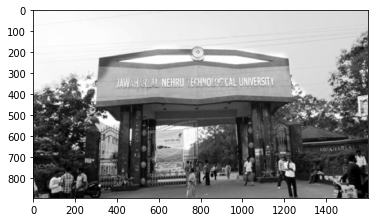

In [94]:
base_img = createBaseImage(gray_img,1.6)
plt.imshow(base_img,cmap = plt.get_cmap('gray'))
plt.show()

In [95]:
# Compute the num of Octave required from the OpenCV defalut implementation
def computeNumOfOctaves(base_img):
    return abs(int(round(np.log(min(base_img.shape))) / (np.log(2)-2) ))

In [96]:
num_of_octaves  = computeNumOfOctaves(base_img)
num_of_octaves

5

In [97]:
# generates gaussian kernals which can be applied to sucessive images
def generateGaussianKernals(sigma=1.6, intvals=3):
    num_of_images_per_octave  = intvals+3
    k  =  2.**(1./intvals)
    sig = np.zeros(num_of_images_per_octave)
    sig[0] = sigma
    sig[1] = sigma*np.sqrt((k**2)-1) # sqrt(((sigma*k)**2)-(sigma**2))
    for i in range(2, num_of_images_per_octave):
        sig[i]=sig[i-1]*k
    return sig

In [98]:
sig = generateGaussianKernals()
sig

array([1.6       , 1.2262735 , 1.54500779, 1.94658784, 2.452547  ,
       3.09001559])

In [99]:
def buildGaussianPyr(base, octvs, sig, intvals=3):
    gaussianPyr=[]
    for o in range(octvs):
        octave =  []
        octave.append(base)
        for i in range(1,intvals+3):
            octave.append(GaussianBlur( octave[i-1], None, sigmaX = sig[i], sigmaY = sig[i]))
        gaussianPyr.append(octave)
        base = resize(octave[-3], (octave[-3].shape[1]//2, octave[-3].shape[0]//2), interpolation = INTER_NEAREST)
    return gaussianPyr

In [100]:
gaussianPyr = buildGaussianPyr(base_img, num_of_octaves, sig)

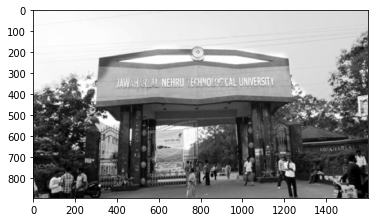

In [101]:
plt.imshow(gaussianPyr[0][0], cmap = plt.get_cmap('gray'))
plt.show()

In [102]:
def applyDoG(gaussianPyr, intvals=3):
    D=[]
    for octave in gaussianPyr:
        a = np.subtract(octave[0],octave[1])
        for i in range(1, (intvals+3)-1):
            tmp =np.subtract(octave[i],octave[i+1])
            a = np.dstack((a,tmp))
        D.append(a)
    return D

In [103]:
d = applyDoG(gaussianPyr)

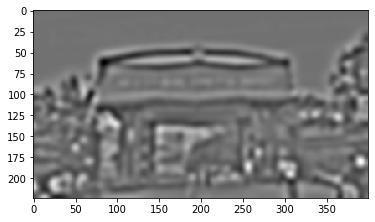

In [104]:
plt.imshow(d[2][:,:,4], cmap = plt.get_cmap('gray'))
plt.show()

In [105]:
# def NormalizePyr(d, num_of_octaves):
#     for o in range(num_of_octaves):
#         for i in range(d[o].shape[2]):
#             img = d[o][:,:,i]
#             Imin = img.min()
#             Imax = img.max()
#             s = img.shape
#             d[o][:,:,i] = (1/(Imax-Imin))*np.subtract(img, np.ones(s)*Imin)
#     return d

In [106]:
d[0][:,:,1].min()

-13.496088506481883

## FINDING AND REFINING EXTREMA POINTS

In [107]:
def isExtrema(patchCude):
    if np.argmax(patchCude)==13 or np.argmax(patchCude)==13:
        return True
    return False

In [108]:
def deriv3D(patchCube):
    #we gonna use central difference mask for computing gradient [-1 0 1] same with the case of y and s
    dx = (patchCube[2,1,1]-patchCube[0,1,1])*0.5
    dy = (patchCube[1,2,1]-patchCube[1,0,1])*0.5
    ds = (patchCube[1,1,2]-patchCube[1,1,0])*0.5
    return np.array([dx,dy,ds])

In [109]:
def hessian3D(patchCube):
    #same central diference operation
    val = patchCube[1,1,1]
    dxx = patchCube[2,1,1]-(2*val)+patchCube[0,1,1]
    dyy = patchCube[1,2,1]-(2*val)+patchCube[1,0,1]
    dss = patchCube[1,1,2]-(2*val)+patchCube[1,1,0]
    dxy = ((patchCube[2,2,1]-patchCube[0,2,1])-(patchCube[2,0,1]-patchCube[0,0,1]))*0.25
    dxs = ((patchCube[2,1,2]-patchCube[0,1,2])-(patchCube[2,1,0]-patchCube[0,1,0]))*0.25
    dys = ((patchCube[1,2,2]-patchCube[1,0,2])-(patchCube[1,2,0]-patchCube[1,0,0]))*0.25
    return np.array([[dxx, dxy, dxs], 
                     [dxy, dyy, dys],
                     [dxs, dys, dss]])

In [110]:
def interpolateStep(patchCude):
    gradient = deriv3D(patchCude)
    hessian = hessian3D(patchCude)
    Xhat = -LA.lstsq(hessian, gradient, rcond=None)[0]
    return Xhat, gradient, hessian

In [111]:
def interpolateContr(patchCube, gradient, Xhat):
    return patchCube[1, 1, 1] + 0.5 * np.dot(gradient, Xhat)

In [112]:
"""
    Returns the feature resulting from interpolation of the given
    parameters or NULL if the given location could not be interpolated or
    if contrast at the interpolated loation was too low.  If a feature is
    returned, its scale, orientation, and descriptor are yet to be determined.
"""
def refineExtema(octave, octave_index, intvls, image_index, i, j, contr_thr, eigen_ratio, sigma, MAX_INTERATION_STEPS, SIFT_IMG_BORDER):
    counter=0
    while counter<MAX_INTERATION_STEPS:
        patchCube = octave[i-1:i+2,j-1:j+2,image_index-1:image_index+2]
        patchCube = patchCube.astype(np.float32)/255
        Xhat ,gradient, hessian= interpolateStep(patchCube)
        if abs(Xhat[0])<0.5 and abs(Xhat[1])<0.5 and abs(Xhat[2])<0.5:
            break
        j+=int(round(Xhat[0]))
        i+=int(round(Xhat[1]))
        image_index+=int(round(Xhat[2]))
        if image_index<1 or image_index>intvls+3 or i<SIFT_IMG_BORDER or j<SIFT_IMG_BORDER or i>=octave[image_index].shape[0]-SIFT_IMG_BORDER or j>=octave[image_index].shape[1]-SIFT_IMG_BORDER:
            return None
        counter+=1
    #ensure convergence of interpolation
    if counter>=MAX_INTERATION_STEPS:
        return None
    
    contr = interpolateContr(patchCube, gradient, Xhat)
    if abs(contr)*intvls < contr_thr:
        return None
    
    xy_hessian = hessian[:2,:2]
    xy_trace = np.trace(xy_hessian)
    xy_det = LA.det(xy_hessian)
    if xy_det>0 and eigen_ratio*(xy_trace**2)<((eigen_ratio+1)**2)*xy_det:
        keypoint = KeyPoint()
        # KeyPoint is from opencv to it stores all required info regarding a Keypoint
        keypoint.pt = ((j + Xhat[0]) * (2 ** octave_index), (i + Xhat[1]) * (2 ** octave_index))
        keypoint.octave = octave_index + image_index * (2 ** 8) + int(round((Xhat[2] + 0.5) * 255)) * (2 ** 16)
        keypoint.size = sigma * (2 ** ((image_index + Xhat[2]) / np.float32(intvls))) * (2 ** (octave_index + 1))  # octave_index + 1 because the input image was doubled
        keypoint.response = abs(contr)
        return keypoint, image_index
    return None

In [113]:
def scaleSapceExtrema(D, octvs, intvals, contr_thr = 0.03, SIFT_IMAGE_BORDER=5):
    keypoints = []
    prelim_contr_thr = 0.5*(contr_thr/intvals)/255
    for octave_index, octave in enumerate(D):
        for image_index in range(1,octave.shape[2]-1):
            for i in range(SIFT_IMAGE_BORDER, octave[:,:,image_index].shape[0]-SIFT_IMAGE_BORDER):
                for j in range(SIFT_IMAGE_BORDER, octave[:,:,image_index].shape[1]-SIFT_IMAGE_BORDER):
                    patchCube = octave[i-1:i+2,j-1:j+2,image_index-1:image_index+2]
                    intensity = patchCube[1,1,1]
                    if intensity>prelim_contr_thr:
                        if isExtrema(patchCube):
                            result = refineExtema(octave, octave_index, 3, image_index, i, j, contr_thr, 10, 1.6, 5, SIFT_IMAGE_BORDER)
                            if result is not None:
                                keypoint, refined_image_index = result
                                keypoints.append(keypoint)
    return keypoints

In [114]:
keypoints = scaleSapceExtrema(d, num_of_octaves, 3)

In [115]:
len(keypoints)

1483

In [116]:
from cv2 import imwrite, circle
img_copy = imread('jntu1.jpeg')
img_copy=createBaseImage(img_copy,1.6)
for k in keypoints:
    j,i = k.pt
    circle(img_copy, (int(j),int(i)), int(round(k.size)), [255,0,0])
imwrite("ss.png", img_copy)

True